In [1]:
import pandas as pd
import keras
import matplotlib.pyplot as plt
from scripts.config import window,test_ratio

2024-05-29 03:36:20.447769: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 03:36:20.450728: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 03:36:20.493090: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 03:36:21.293038: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("../data/scalati.csv.gz")[-10000:]  # I dati sono tanti, non ho una CUDA quindi non posso usarli tutti
df.dropna(inplace=True)
df.head(200)

,uuid,date,steps,sleep_score,n_steps,n_sleep_score
1291394,fe2c5a3fee51af4f62027125aaa6c0b74247b406,0.167582,13867.35,0.723122,0.588031,1.124486
1291395,fe2c5a3fee51af4f62027125aaa6c0b74247b406,0.170330,6848.24,0.716472,-0.999667,1.073170
1291396,fe2c5a3fee51af4f62027125aaa6c0b74247b406,0.173077,15204.16,0.666149,0.890413,0.684798
1291397,fe2c5a3fee51af4f62027125aaa6c0b74247b406,0.175824,19235.33,0.292907,1.802250,-2.195733
1291398,fe2c5a3fee51af4f62027125aaa6c0b74247b406,0.178571,9433.45,0.555619,-0.414902,-0.168232
...,...,...,...,...,...,...
1291589,fe3ac99c5ecac9209440d5954e96fd2265fedbba,0.365385,5530.30,0.565940,-0.605714,0.018786
1291590,fe3ac99c5ecac9209440d5954e96fd2265fedbba,0.368132,7133.17,0.564440,-0.151352,0.005221
1291591,fe3ac99c5ecac9209440d5954e96fd2265fedbba,0.370879,9117.52,0.662308,0.411147,0.890264
1291592,fe3ac99c5ecac9209440d5954e96fd2265fedbba,0.373626,5043.00,0.389076,-0.743848,-1.580635


In [3]:
import numpy as np

xtrain = []
ytrain = []
xtest=[]
ytest=[]
for uuid, group in df.groupby('uuid')[["date","n_steps","n_sleep_score"]]:
    split=int(len(group)*(1-test_ratio))
    if split<window:
        continue
        
    inputs = np.array(group[["date","n_steps"]].values)
    output = np.array(group["n_sleep_score"].values)


    for i in range (window,split):
        xtrain.append(inputs[i-window:i]) # Una finestra di <window> osservazioni sui passi
        ytrain.append(output[i]) # La qualità del sonno alla fine della finestra

    for i in range (split,len(group)):
        xtest.append(inputs[i-window:i])
        ytest.append(output[i])

xtrain=np.array(xtrain).reshape(-1,window,2)
ytrain=np.array(ytrain).reshape(-1,1)
xtest=np.array(xtest).reshape(-1,window,2)
ytest=np.array(ytest).reshape(-1,1)

In [6]:
inputs = keras.Input(shape=(window,2))
lstm_1=keras.layers.LSTM(30)(inputs)
output = keras.layers.Dense(1)(lstm_1)

model=keras.Model(inputs=inputs, outputs=output)
model.compile(loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.R2Score()])
model.summary()

#L'ho definita secondo l'API funzionale di Keras, in modo da poter estrarre le attivazioni dei layer intermedi con facilità

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30)             │         3,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,991 (15.59 KB)

 Trainable params: 3,991 (15.59 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from keras.src.callbacks import EarlyStopping,ModelCheckpoint


history = model.fit(xtrain, ytrain, epochs=20, verbose=1, validation_split=.2,
                    callbacks=[EarlyStopping(monitor='val_r2_score', patience=5),
                               ModelCheckpoint(filepath='best_model.keras', monitor='val_r2_score',
                                               save_best_only=True)])

Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9932 - r2_score: -0.0042 - val_loss: 0.9789 - val_r2_score: 0.0047
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9772 - r2_score: 0.0028 - val_loss: 0.9824 - val_r2_score: 0.0011
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9599 - r2_score: 7.2448e-04 - val_loss: 0.9804 - val_r2_score: 0.0032
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9218 - r2_score: 2.7101e-05 - val_loss: 0.9818 - val_r2_score: 0.0018
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9300 - r2_score: 0.0038 - val_loss: 0.9775 - val_r2_score: 0.0061
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9620 - r2_score: -0.0015 - val_loss: 0.9794 - val_r2_score: 0.0042
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9445 - r2_score: 0.0020 - val_loss: 0.9814 - val_r2_score: 0.0021
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9394 - r2_score: 0.0033 - val_lo

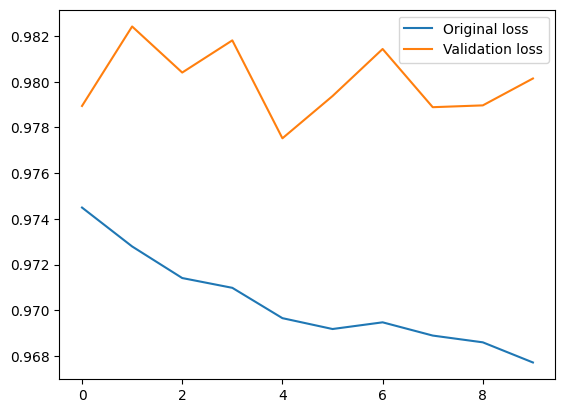

In [8]:
plt.plot(history.history['loss'], label='Original loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [9]:
model.evaluate(xtest, ytest)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0591 - r2_score: -0.0070


[1.058709979057312, -0.015260934829711914]

In [10]:
model.save("../models/modello-passi-sonno-recurrent.keras")

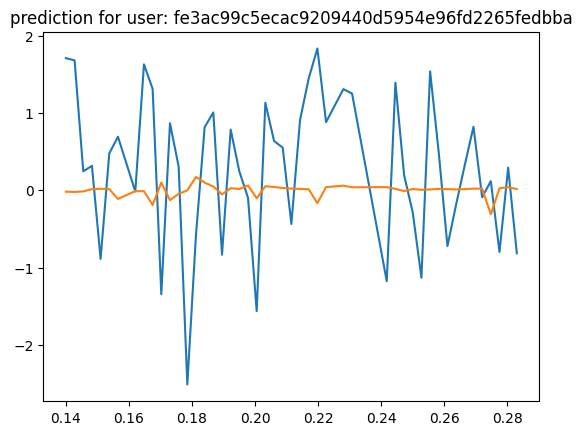

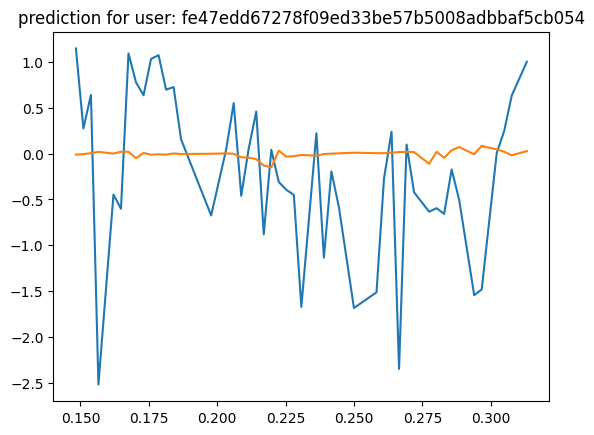

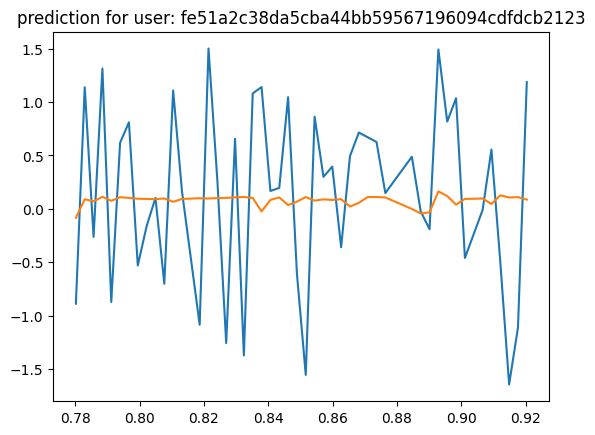

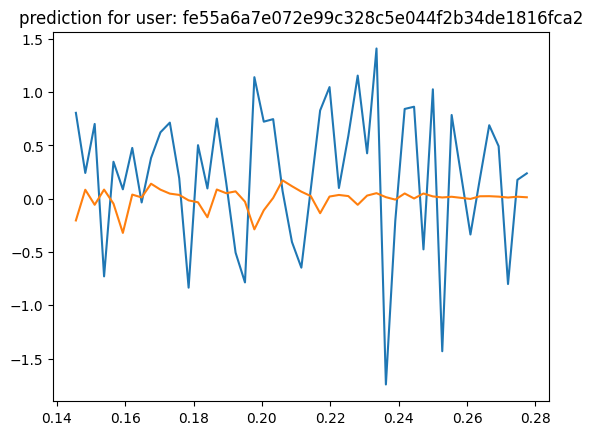

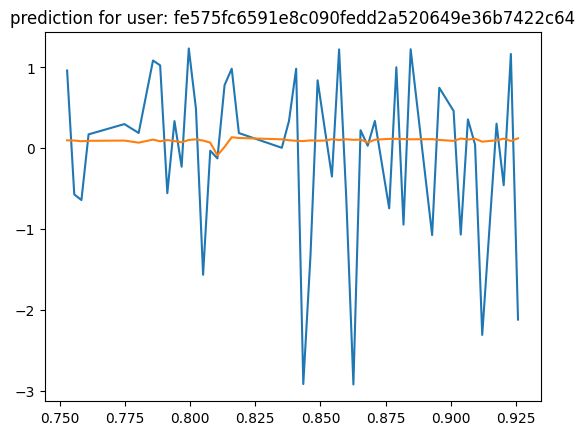

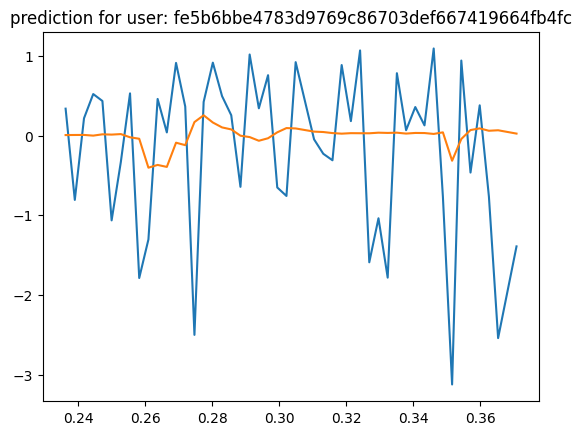

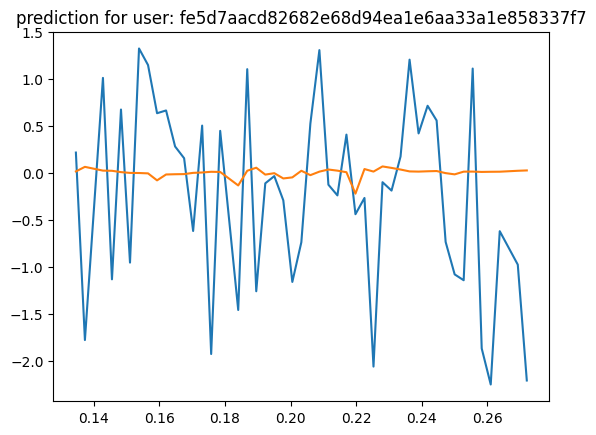

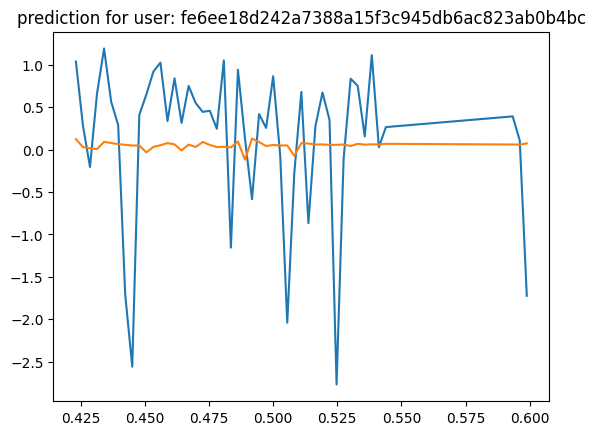

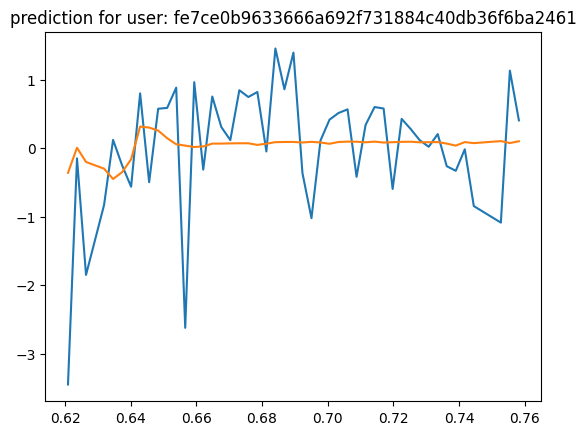

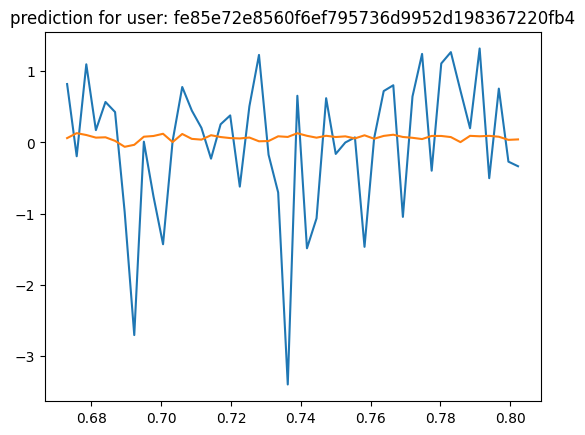

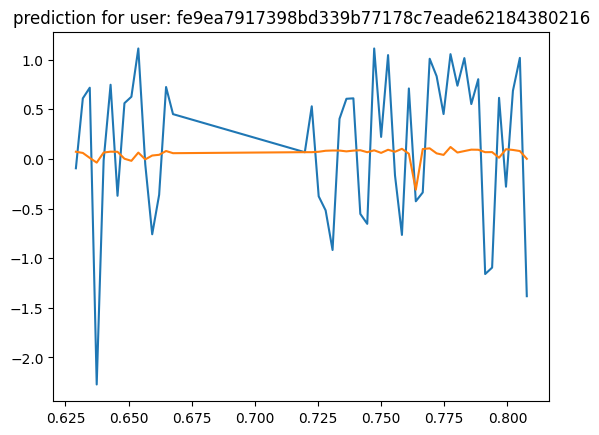

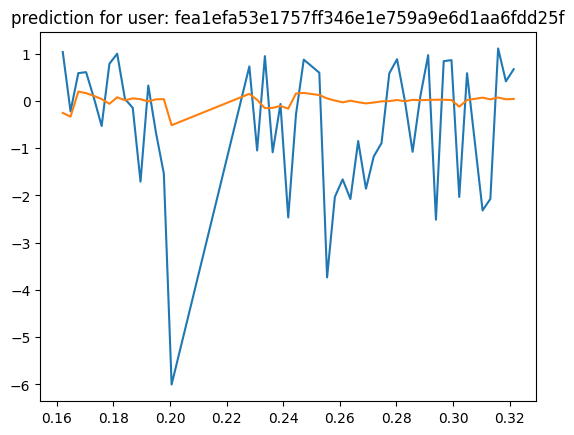

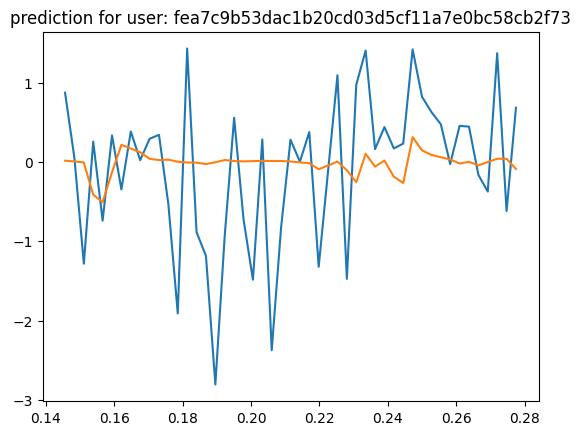

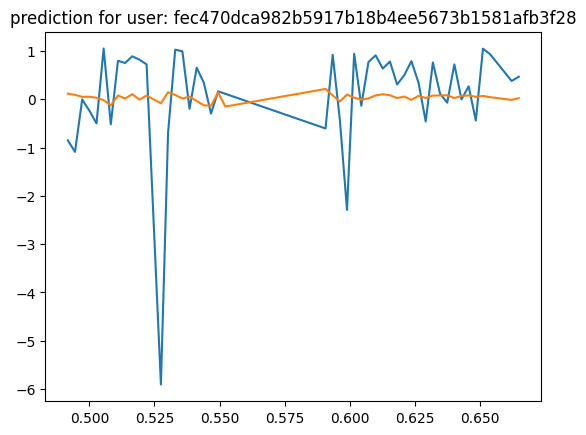

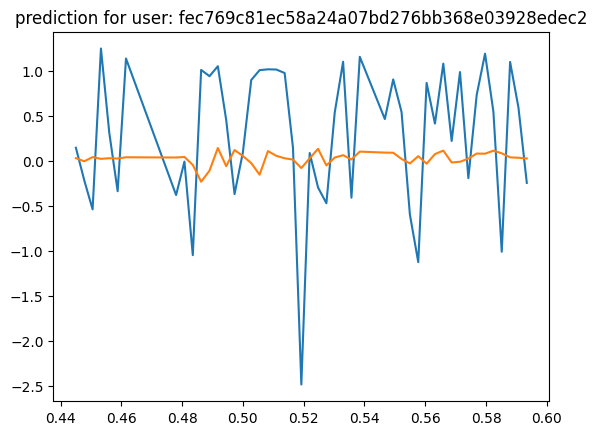

In [ ]:
for uuid,group in df.groupby('uuid'):
    if len(group)<2*window:
        continue
    common = group[["date","n_steps"]].values
    actual = group["n_sleep_score"].values
    data=[]
    for i in range(window,len(common)):
        data.append(common[i - window:i])
    data=np.array(data)
    pred = model.predict_on_batch(data)
    pred=np.array(pred)
    plt.title("prediction for user: "+uuid)
    plt.plot(group["date"][window:2*window],actual[window:2*window],label='Actual')
    plt.plot(group["date"][window:2*window],pred[:window],label='Predicted')
    plt.show()
    plt.close()